# WHO Health Data
## In Correlation with Numbeo Health Index and Numbeo QoL index

This notebook uses the WHO data on access to sanitation services as well as
the Health Regulations core competencies and compares it with the Numbeo data.

In [1]:
# import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
# Read in Numbeo data set
dfNumbeo = pd.read_csv("data/Numbeo.csv",sep=";",decimal=",")
dfNumbeo.columns = ['Period', 'City_Country', 'QualityOfLife',
                    'PurchasingPower', 'Safety', 'HealthCare',
                    'CostOfLiving', 'PropertyPriceToIncomeRatio',
                    'TrafficCommuteTime','Pollution', 'Climate']
# split City_Country into City and Country
City_Country = dfNumbeo['City_Country'].str.split(',', n=1, expand=True)
dfNumbeo['City'] = City_Country[0].str.strip()
dfNumbeo['Country'] = City_Country[1].str.strip()
display(dfNumbeo)

,Period,City_Country,QualityOfLife,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate,City,Country
0,2020,"Caracas, Venezuela",0.00,2.36,15.10,39.28,27.68,150.55,34.69,72.41,99.93,Caracas,Venezuela
1,2020,"Auckland, New Zealand",165.38,83.93,54.54,73.43,76.06,12.09,37.96,29.19,99.89,Auckland,New Zealand
2,2020,"Guatemala City, Guatemala",107.71,40.18,37.39,63.63,44.26,9.89,50.11,69.66,99.89,Guatemala City,Guatemala
3,2020,"Nairobi, Kenya",73.29,24.85,39.92,56.46,42.08,26.17,56.94,80.42,99.79,Nairobi,Kenya
4,2020,"Medellin, Colombia",117.13,29.90,48.66,77.28,30.19,17.90,38.29,64.89,99.76,Medellin,Colombia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,2012-Q1,"Cairo, Egypt",-35.66,18.35,61.33,70.83,52.69,15.51,58.75,129.50,NaN,Cairo,Egypt
2305,2012-Q1,"Tehran, Iran",-50.44,47.52,43.27,43.40,60.86,13.72,73.50,140.75,NaN,Tehran,Iran
2306,2012-Q1,"Moscow, Russia",-54.72,46.75,47.33,37.75,86.77,28.06,61.50,116.61,NaN,Moscow,Russia
2307,2012-Q1,"Kolkata, India",-74.08,49.55,27.97,19.72,32.96,15.13,74.25,145.50,NaN,Kolkata,India


In [3]:
# Read in WHO data: Usage of safely managed sanitation services
dfWHO_sanitation = pd.read_csv('data/WHO_WSH_SANITATION_SAFELY_MANAGED.csv')
# Read in WHO data: sustainable development goals
dfWHO_SDG = pd.read_csv('data/WHO_SDGIHR.csv')
# Read in table of ISO codes
dfISO = pd.read_csv('data/country-iso.csv')
dfISO = dfISO.set_index('alpha-3')
# Enrich WHO data with country names
dfWHO_sanitation = dfWHO_sanitation.join(
    dfISO['name'], on='COUNTRY', how='inner')
dfWHO_SDG = dfWHO_SDG.join(
    dfISO['name'], on='COUNTRY', how='inner')
# filter for urban area (sanitation only)
# only use columns year and numeric
dfWHO_sanitation = dfWHO_sanitation.loc[
    dfWHO_sanitation.RESIDENCEAREATYPE == 'URB',
    ['name', 'YEAR', 'Numeric']]
dfWHO_SDG = dfWHO_SDG.loc[:, ['name', 'YEAR', 'Numeric']]
display(dfWHO_sanitation)
display(dfWHO_SDG)

,name,YEAR,Numeric
2,Albania,2000,39.79776
5,Albania,2001,39.76243
8,Albania,2002,39.72710
11,Albania,2003,39.69178
14,Albania,2004,39.65645
...,...,...,...
3650,Zimbabwe,2013,18.29558
3651,Zimbabwe,2014,17.79461
3652,Zimbabwe,2015,17.29372
3653,Zimbabwe,2016,16.79291


,name,YEAR,Numeric
0,Lao People's Democratic Republic,2017,NaN
644,Lao People's Democratic Republic,2010,51.0
645,Lao People's Democratic Republic,2011,50.0
646,Lao People's Democratic Republic,2012,31.0
647,Lao People's Democratic Republic,2013,55.0
...,...,...,...
1073,Tonga,2013,74.0
1088,Turkmenistan,2011,81.0
1089,Turkmenistan,2014,84.0
1121,Uzbekistan,2011,90.0


In [4]:
# Merge Numbeo with WHO, merge on country & year
# first add country-period column on numbeo
dfNumbeo['Country_Period'] = (
    dfNumbeo['Country'].str[:10] +
    dfNumbeo['Period'].str[:4]
)
# now add similar column on WHO
dfWHO_sanitation['Country_Period'] = (
    dfWHO_sanitation['name'].str[:10] +
    dfWHO_sanitation['YEAR'].astype(str)
)
dfWHO_SDG['Country_Period'] = (
    dfWHO_SDG['name'].str[:10] +
    dfWHO_SDG['YEAR'].astype(str)
)
# Now merge with sanitation
dfMerged = dfNumbeo.merge(
    dfWHO_sanitation,
    on='Country_Period',
    how='inner'
)
# Renamed column 'Numeric' to 'Sanitation'
dfMerged.rename(columns={'Numeric':'Sanitation'}, inplace=True)
# Now merge with SDG
dfMerged = dfMerged.merge(
    dfWHO_SDG,
    on='Country_Period',
    how='inner'
)
# Renamed column 'Numeric' to 'SDG'
dfMerged.rename(columns={'Numeric':'SDG'}, inplace=True)
# correlation between HealthCare and Sanitation
display(dfMerged.HealthCare.corr(dfMerged.Sanitation, method='spearman'))
# correlation between HealthCare and SDG
display(dfMerged.HealthCare.corr(dfMerged.SDG, method='spearman'))
# correlation between Sanitation and QoL
display(dfMerged.QualityOfLife.corr(dfMerged.Sanitation, method='spearman'))
# correlation between SDG and QoL
display(dfMerged.QualityOfLife.corr(dfMerged.SDG, method='spearman'))
# display(dfMerged)

0.493655379640088

0.08941727891057168

0.542428204331822

0.29177105476307286

<Figure size 936x936 with 0 Axes>

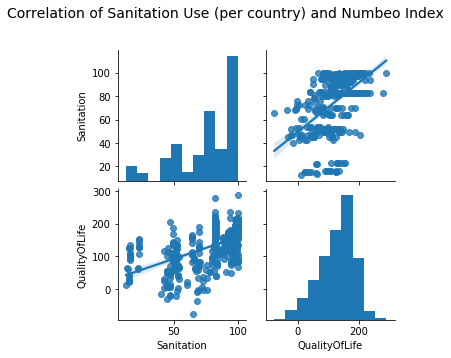

In [5]:
fig = plt.figure(figsize=(13,13))
g = sns.pairplot(dfMerged.loc[:,['Sanitation','QualityOfLife']],kind="reg")
g.fig.suptitle("Correlation of Sanitation Use (per country) and Numbeo Index", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.85,left=0.2,bottom=0.1)
g.fig.savefig('visuals/CorrelationWHO_Sanitation_QoL.png')

In [6]:
# fit a model
lm = smf.ols(formula='QualityOfLife ~ Sanitation + SDG', data=dfMerged).fit()
# print the full summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          QualityOfLife   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     86.73
Date:                Sat, 25 Jan 2020   Prob (F-statistic):           2.00e-32
Time:                        18:18:52   Log-Likelihood:                -2330.3
No. Observations:                 438   AIC:                             4667.
Df Residuals:                     435   BIC:                             4679.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3873     17.757      0.416      0.678     -27.512      42.287
Sanitation     1.3011      0.106     12.218      0.000       1.092       1.510
SDG            0.2319      0.203      1.144      0.253      -0.167       0.630
==============================================================================
Omnibus:                       16.297   Durbin-Watson:                   0.653
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.106
Skew:                          -0.455   Prob(JB):                     0.000193
Kurtosis:                       3.332   Cond. No.                         894.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Read in GDP data from WorldBank
dfWorldbankGDP = pd.read_csv(
    'data/Worldbank_GDP_per_capita.csv',
    skiprows=4)
# make Country Name into index
dfWorldbankGDP = dfWorldbankGDP.set_index('Country Name')

In [8]:
# add in GDP into dfMerged
gdp = []
for index, row in dfMerged.iterrows():
    country = row['Country']
    year = row['Period'][:4]
    try:
        gdp.append(dfWorldbankGDP.loc[country, year])
    except:
        gdp.append(np.nan)
dfMerged['GDP'] = gdp

<Figure size 936x936 with 0 Axes>

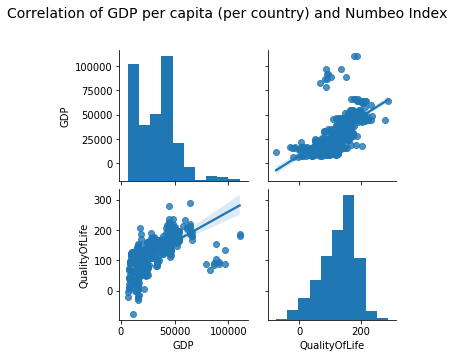

In [9]:
fig = plt.figure(figsize=(13,13))
g = sns.pairplot(dfMerged.loc[:,['GDP','QualityOfLife']],kind="reg")
g.fig.suptitle("Correlation of GDP per capita (per country) and Numbeo Index", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.85,left=0.2,bottom=0.1)
g.fig.savefig('visuals/CorrelationGDP_QoL.png')

In [10]:
# fit a model
lm = smf.ols(formula='QualityOfLife ~ Sanitation + GDP', data=dfMerged).fit()
# print the full summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          QualityOfLife   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     147.8
Date:                Sat, 25 Jan 2020   Prob (F-statistic):           2.37e-49
Time:                        18:18:53   Log-Likelihood:                -2207.3
No. Observations:                 424   AIC:                             4421.
Df Residuals:                     421   BIC:                             4433.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.8463      7.382      5.398      0.000      25.336      54.357
Sanitation     0.4962      0.127      3.918      0.000       0.247       0.745
GDP            0.0015      0.000      9.322      0.000       0.001       0.002
==============================================================================
Omnibus:                       51.491   Durbin-Watson:                   0.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.141
Skew:                          -0.807   Prob(JB):                     2.92e-17
Kurtosis:                       4.306   Cond. No.                     1.32e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# correlation between GDP and QoL
display(dfMerged.QualityOfLife.corr(dfMerged.GDP, method='spearman'))

0.7386219841522873

In [12]:
# Read in Emissions costs data from WorldBank
dfWorldbankEmissions = pd.read_csv(
    'data/Worldbank_Emissions_Damage.csv',
    skiprows=4)
# make Country Name into index
dfWorldbankEmissions = dfWorldbankEmissions.set_index('Country Name')

In [13]:
# add in emissions damage into dfMerged
emissions = []
for index, row in dfMerged.iterrows():
    country = row['Country']
    year = row['Period'][:4]
    try:
        emissions.append(dfWorldbankEmissions.loc[country, year])
    except:
        emissions.append(np.nan)
dfMerged['Emissions'] = emissions

<Figure size 936x936 with 0 Axes>

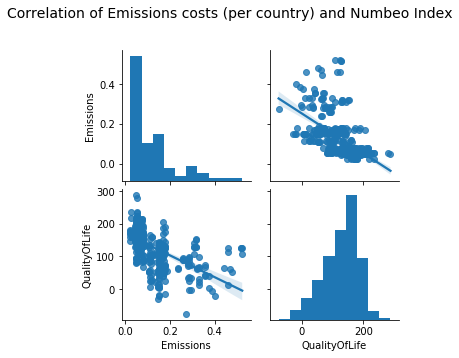

In [14]:
fig = plt.figure(figsize=(13,13))
g = sns.pairplot(dfMerged.loc[:,['Emissions','QualityOfLife']],kind="reg")
g.fig.suptitle("Correlation of Emissions costs (per country) and Numbeo Index", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.85,left=0.2,bottom=0.1)
g.fig.savefig('visuals/CorrelationEmissions_QoL.png')

In [15]:
# correlation between Emissions and QoL
display(dfMerged.QualityOfLife.corr(dfMerged.Emissions, method='spearman'))

-0.6874969066262762

In [16]:
# fit a model
lm = smf.ols(
    formula='QualityOfLife ~ Sanitation + GDP + Emissions',
    data=dfMerged).fit()
# print the full summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          QualityOfLife   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     108.3
Date:                Sat, 25 Jan 2020   Prob (F-statistic):           1.09e-51
Time:                        18:18:54   Log-Likelihood:                -2154.2
No. Observations:                 415   AIC:                             4316.
Df Residuals:                     411   BIC:                             4333.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     84.7883     12.145      6.981      0.000      60.914     108.663
Sanitation     0.2822      0.135      2.087      0.037       0.016       0.548
GDP            0.0012      0.000      6.669      0.000       0.001       0.002
Emissions   -142.6925     30.838     -4.627      0.000    -203.312     -82.073
==============================================================================
Omnibus:                       29.841   Durbin-Watson:                   0.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.310
Skew:                          -0.580   Prob(JB):                     4.80e-09
Kurtosis:                       3.933   Cond. No.                     5.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""